In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

In [2]:
from bluesky_tutorial_utils import setup_data_saving
from bluesky import RunEngine
from bluesky.plans import count
from utils import simple_integration

RE = RunEngine()
catalog = setup_data_saving(RE)

In [3]:
from simulated_hardware import detector, shutter, load_sample, unload_sample, light, time_travel, current_time, _history, history_reset, make_decay_func, sim_sleep

### Plan

---- Part A: Single image collection and integration

1.) Introduce simulation, allow that we will move between samples and 'in time', get to time-machine later in demo.

2.) Manually take a light image, look at it. (behind the scenes, move time forward in big steps)

3.) Introduce idea of a dark image.  Explain that we need to turn off light (or remove sample), and acquire a dark.

4.) Gather dark image, gather light image, subtract, see difference.

6.) Integrate image to get 1D pattern, compare to ideal data, see it's pretty good.

---- Part B: Multiple samples and introductory time travel


1.) Show how we change between samples.

2.) Show how we change time (disable automatic-time).

3.) Talk about how we have an issue if our dark image doesn't match our current background of light (detectors have a bit of a history)

4.) Talk about need to taylor our data collection plan (frequency of darks) as a function of how strong scatterers are.  (note - this is why we avoid measuring weak scattering samples directly after strong).

5.) Make a plan based around these timing considerations, collect data, show things worked well.
--- Part C: Optional "High-Score" mode

1.) Say you want to measure sample multiple times, add up results to improve statistics

2.) Demonstrate how to do this (and that it improves things for weakly scattering samples)

3.) Explain that in real life, can't just measure forever, need to prioritize and decide how to use your beamtime

4.) Game is to get the 'best score' by arranging data collection strategy over a limited period of time, compare to ideal data.

5.) High-score list???

Need to Add:

1.)  Slowly varying dark as a function of time.

2.)  Automatic time forwarding (or not) upon excecuting a measurment on detector.

3.)  Think about high-score list capability?  Publishing results to a collective text-file or something?





### Part A

Introduction bits go here.


In [78]:
#set our detector characteristics
_history['panel_amp'] = 50 #50
_history['noise'] = 50
_history['panel_oset'] = 10
_history['panel_wid'] = 128
_history['panel_wl'] = 8000 #8000000
_history['action_time'] = 1.0

In [79]:
#reset history
history_reset()

#load sample
RE(load_sample(3))
#turn on light
RE(light(True))

#count
RE(count([detector]))


('549c0843-29de-4042-afba-57ad81bae91c',)

In [80]:
#retrieve image from databroker
my_im = catalog[-1].primary.read().detector_image[0]
#plot
plt.figure()
plt.imshow(my_im)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Take a dark image

In [81]:
#we started at t=0, so we'll just go before then to measure the dark.
#time_travel(-1)

RE(light(False))

sim_sleep(5)

RE(count([detector]))

my_dark = catalog[-1].primary.read().detector_image[0]


sleeping for 5


In [82]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(my_im)
plt.subplot(122)
plt.imshow(my_dark)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
plt.figure()
plt.imshow(my_im-my_dark)

plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Now to integrate

In [84]:
from simulated_hardware import intensities, x
from utils import simple_integration


In [85]:
intensity = simple_integration(my_im - my_dark,num_bins=301)
#x = np.linspace(0, 30, num=301)


plt.figure()
plt.plot(x, intensities[3], "--", label="ground truth")
plt.plot(x[:len(intensity)], intensity[:], label="'measured'")
plt.legend()
#plt.gcf()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Bluesky Dark Plan

In [65]:
def dark_light_subtract(sample_num):
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    yield from count([detector])
    
    #open shutter
    yield from light(True)
    
    #take light image
    yield from count([detector])
    
    #close shutter to be nice to detector
    yield from light(False)
    


In [66]:
def process_data(pair, return_ims = False):
    #assuming pair is tuple
    my_dark = catalog[pair[0]].primary.read().detector_image[0]
    my_light = catalog[pair[1]].primary.read().detector_image[0]
    if return_ims:
        return my_dark, my_light
    
    this_int = simple_integration(my_light - my_dark,num_bins=301)
    
    return this_int

In [70]:
_history

{'sample': [(5.0, 10.0), (10.0, 15.0), (15.0,)],
 'light': [(2.0, 4.0), (7.0, 9.0), (12.0, 14.0), (17.0, 19.0)],
 'image': [array([[1.92874985e-20, 2.37452948e-20, 2.86971520e-20, ...,
          3.48662284e-20, 2.86971520e-20, 2.37452948e-20],
         [2.37452948e-20, 2.87214639e-20, 3.49149476e-20, ...,
          4.24972244e-20, 3.49149476e-20, 2.87214639e-20],
         [2.86971520e-20, 3.49149476e-20, 4.25310975e-20, ...,
          5.11264242e-20, 4.25310975e-20, 3.49149476e-20],
         ...,
         [3.48662284e-20, 4.24972244e-20, 5.11264242e-20, ...,
          6.26631589e-20, 5.11264242e-20, 4.24972244e-20],
         [2.86971520e-20, 3.49149476e-20, 4.25310975e-20, ...,
          5.11264242e-20, 4.25310975e-20, 3.49149476e-20],
         [2.37452948e-20, 2.87214639e-20, 3.49149476e-20, ...,
          4.24972244e-20, 3.49149476e-20, 2.87214639e-20]]),
  array([[1.92874985e-20, 2.37452948e-20, 2.86971520e-20, ...,
          3.48662284e-20, 2.86971520e-20, 2.37452948e-20],
        

In [76]:
_history['panel_amp'] = 0
_history['decay_a'] = 500 #1000 default was

run_pairs = {}
history_reset()
for i in range(4):
    print ('time is now '+str(current_time()))
    run_pairs[i] = RE(dark_light_subtract(i))
    sim_sleep(10)
    #sim_sleep(50) #was 30


time is now 0
shutter already in requested state
something empty
something empty
sleeping for 10
time is now 15.0
shutter already in requested state
sleeping for 10
time is now 30.0
shutter already in requested state
sleeping for 10
time is now 45.0
shutter already in requested state
sleeping for 10


In [71]:
plt.figure(figsize=(9,3))
run_num = 1
dark_im, light_im = process_data(run_pairs[run_num],return_ims=True)
plt.subplot(131)
plt.imshow(dark_im,vmax=600)
plt.subplot(132)
plt.imshow(light_im,vmax=600)
plt.subplot(133)
plt.imshow(light_im-dark_im,vmax=600)
#plt.colorbar()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [77]:
plt.figure()
for i in run_pairs.keys():
    plt.plot(process_data(run_pairs[i])-i*300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [51]:
%matplotlib widget

In [52]:
plt.figure()
for i in run_pairs.keys():
    plt.plot(process_data(run_pairs[i])-i*300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
plt.close()

In [19]:
ilist2 = np.array(ilist2)
plt.figure()
#plt.plot(ilist2.mean(axis=0))
plt.plot(ilist2.T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
my_dark2 = catalog[-2].primary.read().detector_image[0]
my_light2 = catalog[-1].primary.read().detector_image[0]

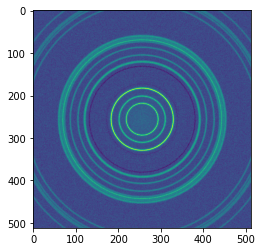

In [32]:
plt.figure()
plt.imshow(my_light2-my_dark2)

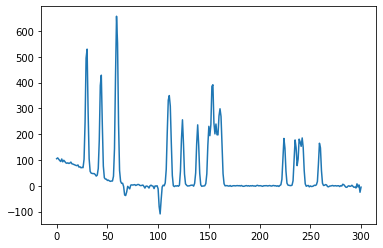

In [33]:
intensity = simple_integration(my_light2 - my_dark2,num_bins=301)
plt.figure()
plt.plot(intensity)

In [24]:
from simulated_hardware import shutter

In [27]:
shutter.read()['shutter']['value']

'closed'

In [19]:
RE(light(False))

current time is 0


()

In [17]:
history_reset()

current time is 14.0


In [33]:
plt.figure()
plt.plot(intensity)

/home/dan/miniconda3/envs/bluesky-tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
from simulated_hardware import intensities, generate_image, patterns, sample_selector

In [16]:
sample_selector.read()['sample_selector']['value']

3

In [9]:
plt.figure()
plt.plot(intensities[_history['sample']])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: unhashable type: 'list'

In [48]:
plt.figure()
plt.imshow(generate_image(x, intensities[1], (512,512)))

/home/dan/miniconda3/envs/bluesky-tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
plt.figure()
plt.imshow(patterns[1])

/home/dan/miniconda3/envs/bluesky-tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
#reset history
history_reset()

time_travel(5)
#load sample
RE(load_sample(2))
#turn on light
RE(light(True))

time_travel(10)
RE(unload_sample())

#count
#RE(count([detector]))


()

In [38]:
_history['noise'] = 0.0

In [39]:
tlist = np.linspace(0,20,21)
intensity_list = []
t0 = time.time()
for t in tlist:
    time_travel(t)
    RE(count([detector]))
    data = catalog[-1].primary.read()
    #this next line is a bit of a piece of work... trying to make a list of total intensities on detector
    #first grabbing image from xarray, then turing into numpy array, then summing, then appending to list.
    intensity_list.append(np.sum(np.array(data.detector_image[0]))) 
print ('this took '+str(time.time()-t0))

this took 50.31184792518616


In [44]:
%matplotlib widget

In [45]:
plt.figure()
plt.imshow(data.detector_image[0])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
max(intensity_list)

130089964.53468667

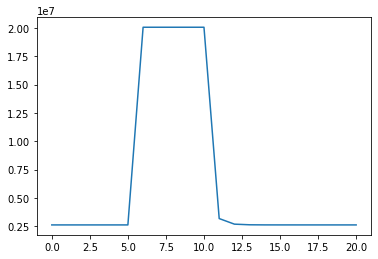

In [40]:
plt.figure()
plt.plot(tlist, intensity_list)
#plt.plot(tlist, intensity_list_was,alpha=.5)